In [1]:
import torch
import numpy as np
import pandas as pd
from local_dataset_utilities import *
from local_utilities import *
from lightning.pytorch.callbacks import ModelCheckpoint
import lightning as L
from lightning.pytorch.loggers import CSVLogger


In [2]:
download_dataset()

In [3]:
df = load_dataset_into_to_dataframe()
df

100%|██████████| 50000/50000 [00:23<00:00, 2131.80it/s]

Class distribution: [25000 25000]


,text,label
0,I went and saw this movie last night after bei...,1
0,Actor turned director Bill Paxton follows up h...,1
0,As a recreational golfer with some knowledge o...,1
0,"I saw this film in a sneak preview, and it is ...",1
0,Bill Paxton has taken the true story of the 19...,1
...,...,...
0,"Towards the end of the movie, I felt it was to...",0
0,This is the kind of movie that my enemies cont...,0
0,I saw 'Descent' last night at the Stockholm Fi...,0
0,Some films that you pick up for a pound turn o...,0


In [4]:
partition_dataset(df)

In [5]:
df_train = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
cv = CountVectorizer(lowercase=True,max_features=10_000,stop_words="english")
cv

,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None
,"stop_words stop_words: {'english'}, list, default=NoneIf 'english', a built-in stop word list for English is used.There are several known issues with 'english' and you shouldconsider an alternative (see :ref:`stop_words`).If a list, that list is assumed to contain stop words, all of whichwill be removed from the resulting tokens.Only applies if ``analyzer == 'word'``.If None, no stop words will be used. In this case, setting `max_df`to a higher value, such as in the range (0.7, 1.0), can automatically detectand filter stop words based on intra corpus document frequency of terms.",'english'
,"token_pattern token_pattern: str or None, default=r""(?u)\\b\\w\\w+\\b""Regular expression denoting what constitutes a ""token"", only usedif ``analyzer == 'word'``. The default regexp select tokens of 2or more alphanumeric characters (punctuation is completely ignoredand always treated as a token separator).If there is a capturing group in token_pattern then thecaptured group content, not the entire match, becomes the token.At most one capturing group is permitted.",'(?u)\\b\\w\\w+\\b'
,"ngram_range ngram_range: tuple (min_n, max_n), default=(1, 1)The lower and upper boundary of the range of n-values for differentword n-grams or char n-grams to be extracted. All values of n suchsuch that min_n <= n <= max_n will be used. For example an``ngram_range`` of ``(1, 1)`` means only unigrams, ``(1, 2)`` meansunigrams and bigrams, and ``(2, 2)`` means only bigrams.Only applies if ``analyzer`` is not callable.","(1, ...)"
,"analyzer analyzer: {'word', 'char', 'char_wb'} or callable, default='word'Whether the feature should be made of word n-gram or charactern-grams.Option 'char_wb' creates character n-grams only from text insideword boundaries; n-grams at the edges of words are padded with space.If a callable is passed it is used to extract the sequence of featuresout of the raw, unprocessed input... versionchanged:: 0.21Since v0.21, if ``input`` is ``filename`` or ``file``, the data isfirst read from the file and then passed to the given callableanalyzer.",'word'


In [8]:
cv.fit(df_train.text)

,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None
,"stop_words stop_words: {'english'}, list, default=NoneIf 'english', a built-in stop word list for English is used.There are several known issues with 'english' and you shouldconsider an alternative (see :ref:`stop_words`).If a list, that list is assumed to contain stop words, all of whichwill be removed from the resulting tokens.Only applies if ``analyzer == 'word'``.If None, no stop words will be used. In this case, setting `max_df`to a higher value, such as in the range (0.7, 1.0), can automatically detectand filter stop words based on intra corpus document frequency of terms.",'english'
,"token_pattern token_pattern: str or None, default=r""(?u)\\b\\w\\w+\\b""Regular expression denoting what constitutes a ""token"", only usedif ``analyzer == 'word'``. The default regexp select tokens of 2or more alphanumeric characters (punctuation is completely ignoredand always treated as a token separator).If there is a capturing group in token_pattern then thecaptured group content, not the entire match, becomes the token.At most one capturing group is permitted.",'(?u)\\b\\w\\w+\\b'
,"ngram_range ngram_range: tuple (min_n, max_n), default=(1, 1)The lower and upper boundary of the range of n-values for differentword n-grams or char n-grams to be extracted. All values of n suchsuch that min_n <= n <= max_n will be used. For example an``ngram_range`` of ``(1, 1)`` means only unigrams, ``(1, 2)`` meansunigrams and bigrams, and ``(2, 2)`` means only bigrams.Only applies if ``analyzer`` is not callable.","(1, ...)"
,"analyzer analyzer: {'word', 'char', 'char_wb'} or callable, default='word'Whether the feature should be made of word n-gram or charactern-grams.Option 'char_wb' creates character n-grams only from text insideword boundaries; n-grams at the edges of words are padded with space.If a callable is passed it is used to extract the sequence of featuresout of the raw, unprocessed input... versionchanged:: 0.21Since v0.21, if ``input`` is ``filename`` or ``file``, the data isfirst read from the file and then passed to the given callableanalyzer.",'word'


In [9]:
X_train = cv.transform(df_train.text)
X_test = cv.transform(df_test.text)
X_val = cv.transform(df_val.text)

#### DataLoader

In [10]:
from torch.utils.data import Dataset,DataLoader

class textDataset(Dataset):
    def __init__(self,x,y): # feature matrix,class labels
        super().__init__()
        self.feature = torch.tensor(x,dtype=torch.float32)
        self.label = torch.tensor(y,dtype=torch.int64)

    def __getitem__(self, index):
        x = self.feature[index]
        y = self.label[index]
        return x,y
    
    def __len__(self):
        return self.label.shape[0]

In [11]:
train_ds = textDataset(X_train.todense(),df_train.label.values)
val_ds = textDataset(X_val.todense(),df_val.label.values)
test_ds = textDataset(X_test.todense(),df_test.label.values)


train_loader = DataLoader(dataset=train_ds,batch_size=32,num_workers=0,shuffle=True)
test_loader = DataLoader(dataset=test_ds,batch_size=32,num_workers=0,shuffle=False)
val_loader = DataLoader(dataset=val_ds,batch_size=32,num_workers=0,shuffle=False)

In [12]:
class LogicRegressionClassifier(torch.nn.Module):
    def __init__(self,num_feature,num_classes):
        super().__init__()
        self.linear = torch.nn.Linear(num_feature,num_classes)

    def forward(self,x):
        logits = self.linear(x)
        return logits

In [13]:
callbacks = [ModelCheckpoint(save_top_k = 1,mode = "max",monitor = "val_acc",save_last = True)]

In [14]:
pytorch_model = LogicRegressionClassifier(num_feature=10_000, num_classes=2)

lightning_model = LightningModel(model=pytorch_model, learning_rate=0.0001)

trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=60,
    accelerator="cpu",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

trainer.fit(model=lightning_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/parthmishra/Desktop/NLP Bag of words/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                      ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ LogicRegressionClassifier │ 20.0 K │ train │     0 │
│ 1 │ train_acc │ MulticlassAccuracy        │      0 │ train │     0 │
│ 2 │ val_acc   │ MulticlassAccuracy        │      0 │ train │     0 │
│ 3 │ test_acc  │ MulticlassAccuracy        │      0 │ train │     0 │
└───┴───────────┴───────────────────────────┴────────┴───────┴───────┘

Trainable params: 20.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 20.0 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 5                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

/Users/parthmishra/Desktop/NLP Bag of words/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/parthmishra/Desktop/NLP Bag of 
words/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader'
does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 
to `num_workers=7` in the `DataLoader` to improve performance.

/Users/parthmishra/Desktop/NLP Bag of 
words/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

`Trainer.fit` stopped: `max_epochs=60` reached.


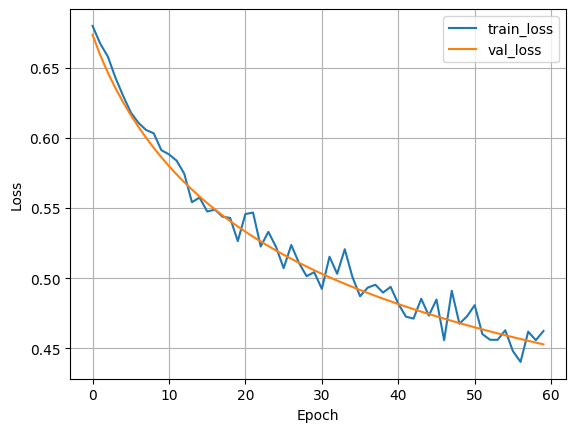

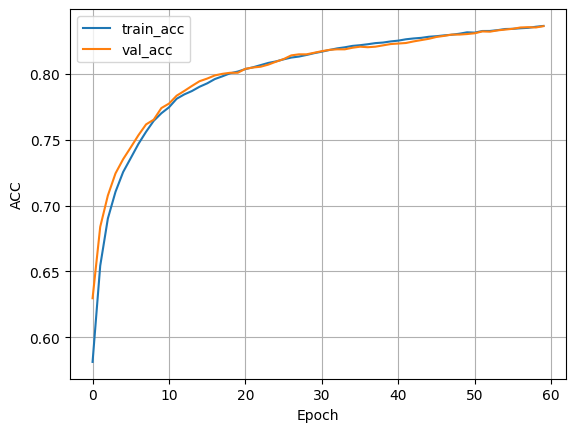

In [15]:
plot_csv_logger(csv_path=f"{trainer.logger.log_dir}/metrics.csv")

In [16]:
trainer.test(model=lightning_model, dataloaders=test_loader)

/Users/parthmishra/Desktop/NLP Bag of words/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/parthmishra/Desktop/NLP Bag of words/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.83160001039505      │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.83160001039505}]

In [19]:
def testing_function(input_text):
    lightning_model.eval()
    with torch.no_grad():
        data = cv.transform([input_text])
        conert = torch.tensor(data.todense(),dtype=torch.float32)
        logits = lightning_model(conert)
        predicted_class = torch.argmax(logits,dim=1)
        return predicted_class

print(testing_function("this is bad movie"))

tensor([0])
